In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData.csv",
                 usecols=['Stop','Station Name','PM10'])

# selecting station #Stockholm E4/E20 Lilla Essingen
#df = df[df['Station Name']=='#Stockholm Torkel Knutssongatan']

# Rename Stop to Time
df = df.rename(columns={"Stop": "Timestamp"})

# convert columns to date
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450646 entries, 0 to 450645
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Timestamp     450646 non-null  datetime64[ns]
 1   Station Name  450646 non-null  object        
 2   PM10          267321 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.3+ MB
None
                PM10
count  267321.000000
mean       18.960425
std        19.918945
min        -3.040000
25%         8.000000
50%        13.400000
75%        22.400000
max       447.600000


In [3]:
from sklearn.preprocessing import MinMaxScaler

## Modyfying data for traning LSTM 

# selecting PM10 column
data_set  = df.iloc[:,2].values

# replace missing values with 0 (later used to mask nan)
nan_index  = np.isnan(data_set)
data_set[np.isnan(data_set)] = 0
print(data_set)
data_set  = data_set.reshape(-1,1)
print("Shape:\n",data_set.shape)
print("Data Set:\n",data_set[0:4])

# Normalisation of Data
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(data_set)
print("Normalised Data Set:\n",data_set_scaled[0:4])

# Generating LSTM featurse with Lag and Y
X = []
y = []
for i in range(5, len(data_set)):
    X.append(data_set_scaled[i-5:i, 0])
    y.append(data_set_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("X:\n",X[0])
print("X shape:\n",X.shape)
print("y:\n",y[0])
print("y shape:\n",y.shape)

[57.  13.  12.8 ...  3.   2.8  4.6]
Shape:
 (450646, 1)
Data Set:
 [[57. ]
 [13. ]
 [12.8]
 [13.9]]
Normalised Data Set:
 [[0.13323274]
 [0.03559382]
 [0.03515001]
 [0.03759098]]
X:
 [[0.13323274]
 [0.03559382]
 [0.03515001]
 [0.03759098]
 [0.03803479]]
X shape:
 (450641, 5, 1)
y:
 0.03870051482336233
y shape:
 (450641,)


In [4]:
## splitting data into test and train
#len of the 
td_percentage = 0.20
test_size = int(len(X)*td_percentage)
X_train = X[0:X.shape[0]-test_size]
y_train = y[0:X.shape[0]-test_size]
X_test = X[0:test_size]
y_test = y[0:test_size]

print("X_train_shape:\n",X_train.shape)
print("y_train_shape:\n",y_train.shape)
print("X_test_shape:\n",X_test.shape)
print("y_test_shape:\n",y_test.shape)

X_train_shape:
 (360513, 5, 1)
y_train_shape:
 (360513,)
X_test_shape:
 (90128, 5, 1)
y_test_shape:
 (90128,)


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Masking

## LSTM Architecture
# input layer
model = Sequential()
# 1
model.add(Masking(mask_value=-1, input_shape = (X.shape[1], 1)))
model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))
# output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile LSTM Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Train the model on the data
history = model.fit(X_train, y_train, epochs = 10,
          batch_size = 70, validation_split=0.33)

Epoch 1/10
3451/3451 [==============================] - 65s 19ms/step - loss: 3.0018e-04 - val_loss: 3.2281e-04
Epoch 2/10
3451/3451 [==============================] - 63s 18ms/step - loss: 2.7402e-04 - val_loss: 3.2408e-04
Epoch 3/10
3451/3451 [==============================] - 66s 19ms/step - loss: 2.6809e-04 - val_loss: 3.2864e-04
Epoch 4/10
3451/3451 [==============================] - 62s 18ms/step - loss: 2.6531e-04 - val_loss: 3.5179e-04
Epoch 5/10
3451/3451 [==============================] - 63s 18ms/step - loss: 2.6302e-04 - val_loss: 3.2847e-04
Epoch 6/10
3451/3451 [==============================] - 63s 18ms/step - loss: 2.6158e-04 - val_loss: 3.5133e-04
Epoch 7/10
3451/3451 [==============================] - 63s 18ms/step - loss: 2.6016e-04 - val_loss: 3.4244e-04
Epoch 8/10
3451/3451 [==============================] - 63s 18ms/step - loss: 2.5925e-04 - val_loss: 3.4034e-04
Epoch 9/10
3451/3451 [==============================] - 62s 18ms/step - loss: 2.5834e-04 - val_loss: 3.3

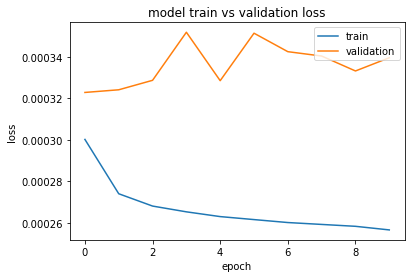

In [7]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [8]:
## Test RMSE
# predicting PM10
predicted_y = model.predict(X_test)
# De-normalising predicted y data
predicted_y = sc.inverse_transform(predicted_y)
# De-normalising actual y data
y_actual = sc.inverse_transform(y_test.reshape(-1,1))
# calculating TEST RMSE
test_rmse = sqrt(mean_squared_error(y_actual, predicted_y))
print('TEST RMSE: '+str(test_rmse))


NameError: name 'sqrt' is not defined